# Introduction

**First : change the runtime and hardware acceleration**

Runtime $\rightarrow$ Change runtime type

- Runtime type : Python 3
- Hardware accelerator : GPU

Here is a notebook that covers the basics about Tensorflow 2.0 using an MNSIT classifier.
You will find the corresponding PowerPoint presentation and the associated PDF (with correct fonts) on [my GitHub page](https://github.com/mgoutay/tf2_tutorial)

The following are discussed :

1. Introduction to Deep Learning
   - See the slides on [GitHub](https://github.com/mgoutay/tf2_tutorial)
2. Tensorflow for beginners
   - What's a Tensor, a TF constant & variable
   - Preparing a dataset
   - Building a model with the Sequential API and training it
3. Tensorflow for experts
   - Creating a Tensorflow dataset
   - Defining new layers with the Subclassing API
   - Composing a model from custom layers
4. Building a custom training loop
   - Defining custom training and testing function, and a custom training loop
   - Building a graph with *@tf.function*
   - Adding regularization
   - Building a custom loss function

# Initialization

Import and initialize everyting that is needed

In [1]:
# Install TensorFlow 2.0 on Google Collab if needed
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

If you selected the GPU hardware acceleration, you should at least see one GPU available :

In [2]:
#Set the GPU you want to use
num_GPU = 0

import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))

if num_GPU < len(gpus):
    tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
    print('Only GPU number', num_GPU, 'used')

Tensorflow version:  2.4.0
Number of GPUs available : 4
Only GPU number 0 used


In [3]:
import os
import copy
import sys
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt  

In [4]:
# Configure the view in Jupyter Notebook
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 100%; }
    div#maintoolbar-container { width: 100%; }
</style>
"""))

# Introduction to Deep Learning

Have a look at the Powerpoint presentation or at the corresponding PDF (with correct fonts) on [my GitHub Page](https://github.com/mgoutay/tf2_tutorial)

# Tensorflow for beginners

Tensorflow 2.0 is **very pythonic**

There is a lot of equivalent functions between Numpy & Tensorflow

In [5]:
import tensorflow as tf

a = tf.constant([[2, 2], [2, 2]], dtype=tf.int32)
b = tf.constant([[3, 3], [4, 4]], dtype=tf.int32)
c = a*b

print(c)

tf.Tensor(
[[6 6]
 [8 8]], shape=(2, 2), dtype=int32)


In [6]:
import numpy as np

a = np.array([[2, 2], [2, 2]], dtype=np.int32)
b = np.array([[3, 3], [4, 4]], dtype=np.int32)
c = a*b

print(c)

[[6 6]
 [8 8]]


The parameters of a NN are created as **Variables**

In [7]:
cst = tf.constant([[2, 2], [2, 2]]) # cst is a fixed Tensor
var = tf.Variable([[2, 2], [2, 2]]) # var will be updated during training

print('cst:', cst, '\n')
print('var:', var, '\n')

cst: tf.Tensor(
[[2 2]
 [2 2]], shape=(2, 2), dtype=int32) 

var: <tf.Variable 'Variable:0' shape=(2, 2) dtype=int32, numpy=
array([[2, 2],
       [2, 2]], dtype=int32)> 



 ### Let’s play with MNIST :
 
 MNIST is large database of handwritten digits 

**Goal** : predict the digit given an image

![MNIST](https://github.com/mgoutay/tf2_tutorial/blob/master/Images/MNIST_all.JPG?raw=true)

**Keras** is a high-level neural networks API

It gives access to pre-made Layers

![keras](https://github.com/mgoutay/tf2_tutorial/blob/master/Images/love.JPG?raw=true)

In [8]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

First step, prepare the dataset

In [9]:
# Load dataset, contains 4 Numpy arrays
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Convert Numpy arrays to Tensors
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32) # [60000, 28, 28]
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32) # [60000]

x_test = tf.convert_to_tensor(x_test, dtype=tf.float32) # [10000, 28, 28]
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32) # [10000]

# Scale the dataset and add a channel dimension
x_train = x_train/255.0 
x_train = tf.expand_dims(x_train, axis=-1) # [60000, 28, 28, 1]

x_test = x_test/255.0 
x_test = tf.expand_dims(x_test, axis=-1) # [10000, 28, 28, 1]

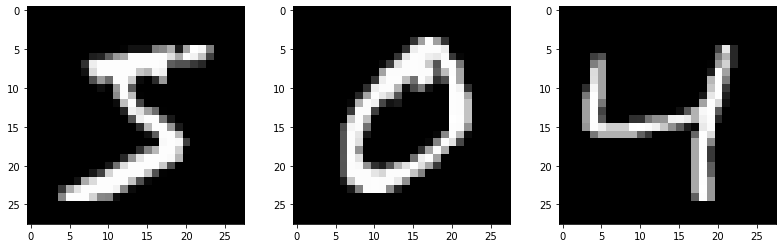

Corresponding labels: tf.Tensor(5, shape=(), dtype=int32), tf.Tensor(0, shape=(), dtype=int32), tf.Tensor(4, shape=(), dtype=int32)


In [10]:
fig = plt.figure(figsize=(3*4.5, 4))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(x_train[i, :, :, 0], cmap='gray')
plt.show()
print('Corresponding labels: '+ str(y_train[0])+ ', '+str(y_train[1])+ ', '+ str(y_train[2]))

Second step, define the model easily with the **Sequential API**

![MNIST](https://github.com/mgoutay/tf2_tutorial/blob/master/Images/MNIST.jpg?raw=true)

In [11]:
my_model = tf.keras.models.Sequential([
    
    Conv2D(filters=6, kernel_size=8, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=15, kernel_size=4, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dense(10, activation='softmax') # Outputs a probability distribution
])

Third, compile, fit, and evaluate the model.

Keras gives access to pre-made functions to help you with that:

In [12]:
my_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Only one correct class
              metrics=['accuracy']) # Percentage of good predictions

Let's create a batch with the 3 first example in the dataset and predict their probabilities :

In [13]:
batch = x_train[:3]
probas = my_model(batch)
print(probas)

tf.Tensor(
[[0.1253427  0.10359064 0.11535894 0.05233655 0.09231059 0.10038295
  0.09623092 0.10626534 0.10591159 0.10226984]
 [0.11591614 0.08989487 0.11211585 0.06449175 0.08511649 0.12014926
  0.10211462 0.1050878  0.10277788 0.10233532]
 [0.11819037 0.10060249 0.11491498 0.07054743 0.09403458 0.09937616
  0.10638811 0.10030549 0.09882545 0.09681483]], shape=(3, 10), dtype=float32)


We can take the $\text{argmax}$ of each vector to see the digit with the highest predicted probability:

In [14]:
predictions = tf.argmax(probas, axis=1)
print(predictions)

tf.Tensor([0 5 0], shape=(3,), dtype=int64)


We need to train the model

<img src="https://github.com/mgoutay/ml_course/blob/master/Images/CE.JPG?raw=true" alt="Drawing" style="width: 700px;"/>

For one example in the batch :
$$ CE = \sum_{j=1}^{C} -p_{j} log (\hat{p}_{j})$$
Averaging on the entire batch :
$$ CE = \frac{1}{Bs} \sum_{i=1}^{Bs} \sum_{j=1}^{C} -p_{i,j} log (\hat{p}_{i,j})$$

**The cross-entropy is a measure of the difference between two probability distributions $p$ and $\hat{p}$**

In [15]:
my_model.fit(x_train, y_train, epochs=10, batch_size=1024)

my_model.evaluate(x_test,  y_test, verbose=2)

Epoch 1/10
59/59 [==============================] - 1s 6ms/step - loss: 1.8343 - accuracy: 0.4753
Epoch 2/10
59/59 [==============================] - 0s 6ms/step - loss: 0.4142 - accuracy: 0.8773
Epoch 3/10
59/59 [==============================] - 0s 6ms/step - loss: 0.2593 - accuracy: 0.9226
Epoch 4/10
59/59 [==============================] - 0s 6ms/step - loss: 0.1976 - accuracy: 0.9415
Epoch 5/10
59/59 [==============================] - 0s 6ms/step - loss: 0.1617 - accuracy: 0.9525
Epoch 6/10
59/59 [==============================] - 0s 6ms/step - loss: 0.1363 - accuracy: 0.9593
Epoch 7/10
59/59 [==============================] - 0s 6ms/step - loss: 0.1197 - accuracy: 0.9646
Epoch 8/10
59/59 [==============================] - 0s 6ms/step - loss: 0.1091 - accuracy: 0.9672
Epoch 9/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0945 - accuracy: 0.9721
Epoch 10/10
59/59 [==============================] - 0s 6ms/step - loss: 0.0888 - accuracy: 0.9733
313/313 - 1s - loss

[0.08419234305620193, 0.9746999740600586]

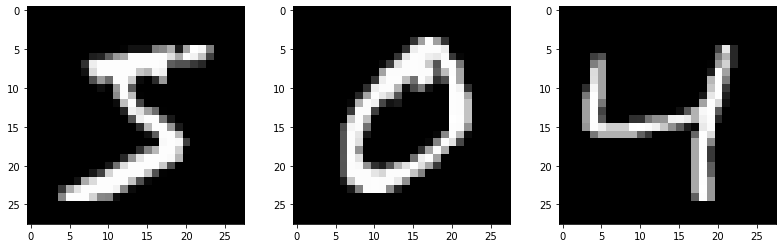

Predictions : 
tf.Tensor([5 0 4], shape=(3,), dtype=int64)


In [16]:
fig = plt.figure(figsize=(3*4.5, 4))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(x_train[i, :, :, 0], cmap='gray')
plt.show()
print('Predictions : ')

predictions = my_model(x_train[:3])
print(tf.argmax(predictions, axis=1))

# Tensorflow for experts

Create a Tensorflow **dataset**. This helps with parallelization.

In [17]:
BATCH_SIZE = 1024

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

Here, we will create the same network ourself, using custom layers, subayers, and model.

![models_equals](https://github.com/mgoutay/tf2_tutorial/blob/master/Images/model_equal.JPG?raw=true)

We can define new layers using the **Sublclassing API**.

Let's define the **ConvPool2D** Layer :
    
![convpool](https://github.com/mgoutay/tf2_tutorial/blob/master/Images/conv_poolJPG.JPG?raw=true)

It inherits form the ``Layer`` class and needs three functions : ``__init__``, ``build``, and ``call``


In [18]:
from tensorflow.keras.layers import Layer

class ConvPool2D(Layer):
    """ Conv2D-relu + MaxPooling2D """
    
    def __init__(self, nb_kernels, kernel_size): # Called at layer creation
        super(ConvPool2D, self).__init__()
        self.nb_kernels = nb_kernels
        self.kernel_size = kernel_size
        
    def build(self, input_shape):  # Called the first time the layer is used
        self.conv_2D = Conv2D(filters=self.nb_kernels,
                              kernel_size=self.kernel_size, 
                              activation='relu')
        self.pool_2D = MaxPooling2D(pool_size=(2, 2))

    def call(self, inputs): # What the layer actually does
        x = self.conv_2D(inputs)
        x = self.pool_2D(x)
        return x

Let us now define a **linear** layer:
![linear](https://github.com/mgoutay/tf2_tutorial/blob/master/Images/linear.JPG?raw=true)

In [19]:
class Linear(Layer):
    """y = Wx + b"""

    def __init__(self, units=32): # Called when creating the layer
        super(Linear, self).__init__()
        self.units = units # units = number of neurons = output shape

    def build(self, input_shape): # Called the first time the layer is used
        self.W = self.add_weight(shape=(self.units, input_shape[-1]), 
                               initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal', trainable=True)

    def call(self, inputs): # What the layer actually does
        return tf.matmul(self.W[tf.newaxis, :, :], inputs[:, :, tf.newaxis])[:, :, 0] + self.b

Layers are **recursively composable** with custom Layers.

Let's define the **DoubleDense** layer :

![DoubleDense](https://github.com/mgoutay/tf2_tutorial/blob/master/Images/double_dense.JPG?raw=true)

In [20]:
class DoubleDense(Layer):
    """" Linear-relu + Linear-Softmax """
    
    def __init__(self, nb_classes): # Called when creating the layer
        super(DoubleDense, self).__init__()
        self.nb_classes = nb_classes
        
    def build(self, input_shape):  # Called the first time the layer is used
        self.linear_1 = Linear(units=128)
        self.linear_2 = Linear(units=self.nb_classes)

    def call(self, inputs): # What the layer actually does
        x = tf.nn.relu(self.linear_1(inputs))
        x = tf.nn.softmax(self.linear_2(x)) # Outputs a probability distribution
        return x

Finally, define the entire model.

The class inherits from the the ``Model`` class and also needs three functions : ``__init__``, ``build``, and ``call``

![model](https://github.com/mgoutay/tf2_tutorial/blob/master/Images/model.JPG?raw=true)

In [21]:
from tensorflow.keras import Model

class MyModel(Model):
    def __init__(self, nb_classes):  # Called when creating the model
        super(MyModel, self).__init__()
        self.nb_classes = nb_classes
    
    def build(self, input_shape):  # Called the first time the layer is used    
        self.conv_pool_1 = ConvPool2D(nb_kernels=6, kernel_size=8)
        self.conv_pool_2 = ConvPool2D(nb_kernels=15, kernel_size=4)
        self.flatten = Flatten()
        self.double_dense = DoubleDense(nb_classes=self.nb_classes)
    
    def call(self, inputs): # What the model actually does
        self.x_0 = self.conv_pool_1(inputs)
        self.x_1 = self.conv_pool_2(self.x_0)
        self.x_2 = self.flatten(self.x_1)
        self.predictions = self.double_dense(self.x_2)
        return self.predictions

Notice how we difined ``x_0``,``x_1``, and ``x_2`` as attributes of the class. This way, their values are saved and can be accessed afterwards if the model is not defined in a graph. This will be shown afterwards.

Then, we create the model using pre-made functions

In [22]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

my_model = MyModel(nb_classes=10)
my_model.compile(optimizer, loss_function)

In [23]:
my_model.fit(train_ds, epochs=3);

Epoch 1/3
59/59 [==============================] - 1s 12ms/step - loss: 1.9103
Epoch 2/3
59/59 [==============================] - 1s 12ms/step - loss: 0.5040
Epoch 3/3
59/59 [==============================] - 1s 12ms/step - loss: 0.3443


In [24]:
my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_pool2d (ConvPool2D)     multiple                  390       
_________________________________________________________________
conv_pool2d_1 (ConvPool2D)   multiple                  1455      
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
double_dense (DoubleDense)   multiple                  18698     
Total params: 20,543
Trainable params: 20,543
Non-trainable params: 0
_________________________________________________________________


# Building a custom training loop

![t_loop](https://github.com/mgoutay/tf2_tutorial/blob/master/Images/Training_loop.JPG?raw=true)

Important **metrics** can be logged

In [25]:
# Define the loss function
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

# Define the metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

The **tf.GradientTape API** provides automatic differentiation. All operations executed inside a gradient tape are recorded.

Let's look at a simple example:
$$x=3$$
$$y=x^2$$
$$\frac{dy}{dx} = 2x = 6$$

We can easily compute that with Tensorflow :

In [26]:
x = tf.Variable(3.0)
with tf.GradientTape() as tape:
    y = tf.square(x)
dy_dx = tape.gradient(y, x)
print(dy_dx)

tf.Tensor(6.0, shape=(), dtype=float32)


We can expand this example to train our model. Let's define the ``training_step`` function, wich computes one SGD step with a given batch.

Simply tape all operations made during the foward path, evaluate the loss function, and let Tensorflow compute the gradients of the loss with respect to our variables (the parameters of the model).

Then, use the optimizer to update the parameters.

Finally, save important metrics.

In [27]:
# One SGD step with a given batch
def train_step(images, labels):
    
    # Open a GradientTape
    with tf.GradientTape() as tape:
        
        #Forward pass
        predictions = my_model(images)
        # Loss for this batch
        loss = loss_function(labels, predictions)
    
    # Get gradients of loss w.r.t. the weights
    gradients = tape.gradient(loss, my_model.trainable_variables)
    # Update the weights according to our optimizer
    optimizer.apply_gradients(zip(gradients, my_model.trainable_variables))
    
    # Save loss and accuracy
    train_loss(loss)
    train_accuracy(labels, predictions)

We can also define a ``test_step`` wich test the model with a test batch

In [28]:
# Test the model on a given batch
def test_step(images, labels):
    
    # Forward pass 
    predictions = my_model(images)
    # Loss for this batch
    t_loss = loss_function(labels, predictions)
    
    # Save loss and accuracy
    test_loss(t_loss)
    test_accuracy(labels, predictions)

Then, we create the training loop.

For each epoch:
1. We train on the entire train dataset
2. We test on the entire test dataset
3. We print the saved matrics
4. We reset every metrics before the next epoch
5. We can measure the time

In [29]:
my_model = MyModel(nb_classes=10)
start = time.time()

# Iterate over 3 epochs
for epoch in range(3):
    # Train over every batch in the training dataset
    for images, labels in train_ds:
        train_step(images, labels)
        
    # Test over every batch in the testing dataset
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    # Print result
    template = 'Epoch {:.0f},   Loss: {:.3f}, Accuracy: {:.3f}    '+ \
               'Test Loss: {:.3f}, Test Accuracy: {:.3f}'
    print(template.format(epoch+1, train_loss.result(), train_accuracy.result()*100,
                          test_loss.result(), test_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

# Display elapsed time
end = time.time()
print('TIME = ', end - start)

Epoch 1,   Loss: 1.435, Accuracy: 62.825    Test Loss: 0.515, Test Accuracy: 83.740
Epoch 2,   Loss: 0.422, Accuracy: 87.392    Test Loss: 0.312, Test Accuracy: 90.730
Epoch 3,   Loss: 0.300, Accuracy: 91.165    Test Loss: 0.244, Test Accuracy: 92.800
TIME =  3.1577506065368652


We can access everything inside the model :

In [30]:
# Without @tf.function
my_model.x_2

<tf.Tensor: shape=(784, 135), dtype=float32, numpy=
array([[1.097259  , 1.7033615 , 0.        , ..., 5.298228  , 3.473796  ,
        1.9050468 ],
       [0.8090348 , 2.217864  , 0.7808752 , ..., 5.4193344 , 5.43804   ,
        4.2131925 ],
       [0.75391763, 1.0787601 , 0.        , ..., 6.2359705 , 3.9661179 ,
        2.550523  ],
       ...,
       [0.8759084 , 1.3610919 , 0.        , ..., 7.360133  , 4.2564344 ,
        2.2974484 ],
       [0.9893374 , 1.7204511 , 0.        , ..., 3.5064578 , 4.094425  ,
        2.751862  ],
       [0.31612268, 1.8312724 , 0.        , ..., 4.859833  , 5.684825  ,
        2.5168583 ]], dtype=float32)>

 ### Building a **graph** to speed up training
 
 This will build the model in the old Tensorflow 1.x way: it is faster but is more like a "black box".
 
You simply have to add the @tf.function decorator before the train_step and test_step function

In [31]:
# One SGD step with a given batch
@tf.function
def train_step(images, labels):
    
    # Open a GradientTape
    with tf.GradientTape() as tape:
        
        #Forward pass
        predictions = my_model(images)
        # Loss for this batch
        loss = loss_function(labels, predictions)
    
    # Get gradients of loss w.r.t. the weights
    gradients = tape.gradient(loss, my_model.trainable_variables)
    # Update the weights according to our optimizer
    optimizer.apply_gradients(zip(gradients, my_model.trainable_variables))
    
    # Save loss and accuracy
    train_loss(loss)
    train_accuracy(labels, predictions)

In [32]:
# Test the model on a given batch
@tf.function
def test_step(images, labels):
    
    # Forward pass 
    predictions = my_model(images)
    # Loss for this batch
    t_loss = loss_function(labels, predictions)
    
    # Save loss and accuracy
    test_loss(t_loss)
    test_accuracy(labels, predictions)

Create a new model and traing it :

In [33]:
my_model = MyModel(nb_classes=10)
start = time.time()

# Iterate over 3 epochs
for epoch in range(3):
    # Train over every batch in the training dataset
    for images, labels in train_ds:
        train_step(images, labels)
        
    # Test over every batch in the testing dataset
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    # Print result
    template = 'Epoch {:.0f},   Loss: {:.3f}, Accuracy: {:.3f}    '+ \
               'Test Loss: {:.3f}, Test Accuracy: {:.3f}'
    print(template.format(epoch+1, train_loss.result(), train_accuracy.result()*100,
                          test_loss.result(), test_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

# Display elapsed time
end = time.time()
print('TIME = ', end - start)

Epoch 1,   Loss: 0.947, Accuracy: 72.533    Test Loss: 0.311, Test Accuracy: 90.740
Epoch 2,   Loss: 0.292, Accuracy: 91.382    Test Loss: 0.240, Test Accuracy: 92.910
Epoch 3,   Loss: 0.228, Accuracy: 93.222    Test Loss: 0.194, Test Accuracy: 94.250
TIME =  3.146338701248169


The training should be much quicker!

But we loose access to the value of the model’s attributes :

In [34]:
# With @tf.function
my_model.x_2

<tf.Tensor 'my_model_2/flatten/Reshape:0' shape=(784, 135) dtype=float32>

### Adding regularization

- Using Keras layers' parameters : see the ``kernel_regularizer`` parameter.

In [35]:
class ConvPool2D(Layer):
    """ Conv2D-relu + MaxPooling2D """

    def __init__(self, nb_kernels, kernel_size): # Called at layer creation
        super(ConvPool2D, self).__init__()
        self.nb_kernels = nb_kernels
        self.kernel_size = kernel_size
        
    def build(self, input_shape):  # Called the first time the layer is used
        self.conv_2D = Conv2D(filters=self.nb_kernels,
                              kernel_size=self.kernel_size, 
                              activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(l=1.))
        self.pool_2D = MaxPooling2D(pool_size=(2, 2))

    def call(self, inputs): # What the layer actually does
        x = self.conv_2D(inputs)
        x = self.pool_2D(x)
        return x

- Using a custom layers' *loss* property

In [36]:
class Linear(Layer):
    """y = Wx + b"""

    def __init__(self, units=32): # Called when creating the layer
        super(Linear, self).__init__()
        self.units = units # units = number of neurons = output shape

    def build(self, input_shape): # Called the first time the layer is used
        self.W = self.add_weight(shape=(self.units, input_shape[-1]), 
                               initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal', trainable=True)

    def call(self, inputs): # What the layer actually does
        self.l1_reg = tf.reduce_sum(tf.abs(self.W)) + tf.reduce_sum(tf.abs(self.b))
        self.add_loss(self.l1_reg)
        return tf.matmul(self.W[tf.newaxis, :, :], inputs[:, :, tf.newaxis])[:, :, 0] + self.b

And adding those losses to the training loop, both in the ``train_step`` and the ``test_step``.

In [37]:
# One SGD step with a given batch
@tf.function
def train_step(images, labels):
    
    # Open a GradientTape
    with tf.GradientTape() as tape:
        
        #Forward pass
        predictions = my_model(images)
        # Loss for this batch
        loss = loss_function(labels, predictions)
        # Add extra losses created during this forward pass:
        loss += 1e-3 * sum(my_model.losses)
    
    # Get gradients of loss w.r.t. the weights
    gradients = tape.gradient(loss, my_model.trainable_variables)
    # Update the weights according to our optimizer
    optimizer.apply_gradients(zip(gradients, my_model.trainable_variables))
    
    # Save loss and accuracy
    train_loss(loss)
    train_accuracy(labels, predictions)

In [38]:
# Test the model on a given batch
@tf.function
def test_step(images, labels):
    
    # Forward pass 
    predictions = my_model(images)
    # Loss for this batch
    t_loss = loss_function(labels, predictions)
    # Add extra losses created during this forward pass:
    t_loss += 1e-3 * sum(my_model.losses)
    
    # Save loss and accuracy
    test_loss(t_loss)
    test_accuracy(labels, predictions)

Create a new model and traing it :

In [39]:
my_model = MyModel(nb_classes=10)
start = time.time()

# Iterate over 3 epochs
for epoch in range(3):
    # Train over every batch in the training dataset
    for images, labels in train_ds:
        train_step(images, labels)
        
    # Test over every batch in the testing dataset
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    # Print result
    template = 'Epoch {:.0f},   Loss: {:.3f}, Accuracy: {:.3f}    '+ \
               'Test Loss: {:.3f}, Test Accuracy: {:.3f}'
    print(template.format(epoch+1, train_loss.result(), train_accuracy.result()*100,
                          test_loss.result(), test_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

# Display elapsed time
end = time.time()
print('TIME = ', end - start)

Epoch 1,   Loss: 1.429, Accuracy: 67.547    Test Loss: 0.699, Test Accuracy: 89.570
Epoch 2,   Loss: 0.628, Accuracy: 90.512    Test Loss: 0.524, Test Accuracy: 92.920
Epoch 3,   Loss: 0.507, Accuracy: 92.902    Test Loss: 0.450, Test Accuracy: 94.030
TIME =  3.452338933944702


### Building a custom loss function

Create a new class, that inherits from the ``Loss`` class.

In [40]:
from tensorflow.keras.losses import Loss

class CustomLoss(Loss):
    """ Custom Sparse Cross Entropy loss with L1 regularization """
    
    def __init__(self, tuning_param): # Called when creating the layer
        super(CustomLoss, self).__init__()
        self.tuning_param = tuning_param
        self.SCE = tf.keras.losses.SparseCategoricalCrossentropy()
        
    def call(self, y_true, y_pred): # What the loss function actually does
        return self.SCE(y_true, y_pred) + self.tuning_param * sum(my_model.losses)

Instantiate the class

In [41]:
cust_loss_function = CustomLoss(tuning_param=1e-3)

Change the loss in the training loop

In [42]:
# One SGD step with a given batch
@tf.function
def train_step(images, labels):
    
    # Open a GradientTape
    with tf.GradientTape() as tape:
        
        #Forward pass
        predictions = my_model(images)
        # Loss for this batch
        loss = cust_loss_function(labels, predictions)
        
    # Get gradients of loss w.r.t. the weights
    gradients = tape.gradient(loss, my_model.trainable_variables)
    # Update the weights according to our optimizer
    optimizer.apply_gradients(zip(gradients, my_model.trainable_variables))
    
    # Save loss and accuracy
    train_loss(loss)
    train_accuracy(labels, predictions)

In [43]:
# Test the model on a given batch
@tf.function
def test_step(images, labels):
    
    # Forward pass 
    predictions = my_model(images)
    # Loss for this batch
    t_loss = cust_loss_function(labels, predictions)
    
    # Save loss and accuracy
    test_loss(t_loss)
    test_accuracy(labels, predictions)

Create a new model and train it :

In [44]:
my_model = MyModel(nb_classes=10)
start = time.time()

# Iterate over 3 epochs
for epoch in range(3):
    # Train over every batch in the training dataset
    for images, labels in train_ds:
        train_step(images, labels)
        
    # Test over every batch in the testing dataset
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    # Print result
    template = 'Epoch {:.0f},   Loss: {:.3f}, Accuracy: {:.3f}    '+ \
               'Test Loss: {:.3f}, Test Accuracy: {:.3f}'
    print(template.format(epoch+1, train_loss.result(), train_accuracy.result()*100,
                          test_loss.result(), test_accuracy.result()*100))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

# Display elapsed time
end = time.time()
print('TIME = ', end - start)

Epoch 1,   Loss: 1.327, Accuracy: 72.692    Test Loss: 0.630, Test Accuracy: 91.030
Epoch 2,   Loss: 0.576, Accuracy: 91.357    Test Loss: 0.488, Test Accuracy: 93.110
Epoch 3,   Loss: 0.473, Accuracy: 93.143    Test Loss: 0.423, Test Accuracy: 94.240
TIME =  3.57198429107666
